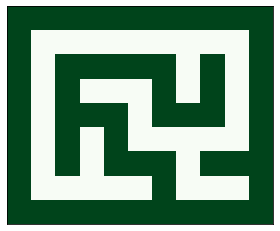

In [1]:
from __future__ import annotations

from enum import Enum
#from dataclasses import dataclass
from typing import Generic, TypeVar, Union, Generator, List, NamedTuple, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np

Coord = Tuple[int, int]

class Coordinate(NamedTuple):
    """
    2d coordinate index

    Attributes
    ----------
    h : int
        height index
    w : int
        width index
    """
    h: T
    w: T

    def __str__(self):
        return f"({self.h}, {self.w})"

    def __add__(self, other: Coordinate):
        """operator `+`"""
        return Coordinate(self.h + other.h, self.w + other.w)

    def __mul__(self, other: Union[Coordinate, int]):
        """operator `*`"""
        if isinstance(other, int):
            return Coordinate(self.h * other, self.w * other)
        else:
            return Coordinate(self.h * other.h, self.w * other.w)

    def add_mul(self, other: Coordinate, mul: T = 1):
        """
        add coordinates, right term multiplied by mul

        Parameters
        ----------
        self : Coordinate
            left term
        other : Coordinate
            right term
        mul: int, default=1
            right term multiplier

        Returns
        -------
        sum : Coord
            `self + other * mul`
        """
        return Coordinate(self.h + other.h * mul, self.w + other.w * mul)


class Directions(Enum):
    """4 displacements of 2d coordinates"""
    RIGHT = Coordinate(0, 1)
    LEFT = Coordinate(0, -1)
    UP = Coordinate(1, 0)
    DOWN = Coordinate(-1, 0)


def random_maze(
        height: int, width: int,
        random_state: Optional[int] = 42, verbose: bool = False
) -> np.ndarray:
    """
    height x width のランダムな迷路を壁伸ばし法で作成

    Notes
    -----
    参考：https://algoful.com/Archive/Algorithm/MazeExtend

    Parameters
    ----------
    height : int (only odd number)
        盤面の高さ (奇数)
    width : int (only odd number)
        盤面の幅 (奇数)
    random_state: int | None, default=42
        random_state for numpy.random
    verbose: bool, default=False
        verbose output when True
    
    Returns
    -------
    maze : ndarray, shape=(height, width), dtype=int
        生成された迷路（壁=1, 道=0）

    Raises
    ------
    ValueError
        * if height or width is not odd
    """
    if not(height % 2 == 1 and width % 2 == 1):
        raise ValueError(
            f"maze size must be (odd, odd) but input is ({height}, {width})")
    np.random.seed(random_state)
    # 最外周だけ壁にする
    maze: np.ndarray = np.zeros((height, width), dtype=int)
    maze[0, :] = 1
    maze[-1, :] = 1
    maze[:, 0] = 1
    maze[:, -1] = 1

    while True:
        # 始点となりうる点を検索
        candidates: list[Coordinate] = []
        for h in range(0, height, 2):
            for w in range(0, width, 2):
                if maze[h, w] == 0:
                    candidates.append(Coordinate(h, w))
        # 偶数座標が埋まりきっていれば終了
        if candidates == []:
            break

        # 始点から始めて既存の壁に到達するまで壁を伸ばす
        start = candidates[np.random.randint(len(candidates))]
        for cood in extend_wall(maze, start, verbose):
            maze[cood] = 1

        if verbose:
            # 生成途中の図を出力
            print("main loop:")
            show_maze(maze)
            plt.show()
    return maze


def extend_wall(
        maze: np.ndarray, start: Coordinate,
        verbose: bool = False
        ) -> list[Coordinate]:
    if verbose:
        print("extend start with:", start)
    """
    始点から始めて既存の壁に到達するまで壁を伸ばす

    Parameters
    ----------
    maze : ndarray, shape=(height, width), dtype=int
        現時点での迷路
    start: Coordinate
        始点
    verbose : bool, defalt=False
        verbose output when True

    Returns
    -------
    building : list[Coordinate]
        始点から既存の壁にたどり着くまでに新たに作った壁の座標リスト
    """
    # 進める方向をランダムに選び，2マスずつ進む．
    # 既存の壁にたどり着いたら完了
    # 自分にぶつかるようなら戻ってやり直す: ここの実装は再帰でやるべき
    curr: Coordinate = start
    building: list[Coordinate] = [start]
    failed: list[Coordinate] = []
    while True:
        *dirs, = search_visitable_dir(maze, curr, building, failed)
        if dirs == []:
            failed.append(curr)
            curr = building.pop()
        else:
            n = len(dirs)
            dir = dirs[np.random.randint(n)]
            building.append(curr + dir)
            if maze[curr.add_mul(dir, 2)] == 1:
                # print(building_stack)
                return building
            curr = curr.add_mul(dir, 2)
            building.append(curr)

        if verbose:
            # 生成途中の図を出力
            maze2:np.ndarray = maze.copy().astype(float)
            for pos in building:
                maze2[pos] = 0.5
            maze2[start] = 0.75
            print("2:")
            show_maze(maze2)
            plt.show()

def search_visitable_dir(
        maze: np.ndarray, curr: Coordinate,
        building_stack: list[Coordinate], failed: List[Coordinate]
) -> Generator[Coordinate, None, None]:
    """
    以下の条件を満たす方向を探す
    * 進んだ先が既存の壁ではない
    * 進んだ先が生成中の壁ではない
    * 進んだ先が既に失敗した座標ではない
    * 2つ進んだ先が生成中の壁ではない

    Parameters
    ----------

    Returns
    -------
    """
    for dir in Directions:
        if maze[curr + dir.value] == 0\
                and curr + dir.value not in building_stack\
                and curr + dir.value not in failed\
                and curr.add_mul(dir.value, 2) not in building_stack:
            yield dir.value


def show_maze(
        maze: Optional[np.ndarray] = None,
        height: int = 7, width: int = 9,
        random_state: Optional[int] = None,
        cmap: str = 'Greens',
        verbose: bool = False):
    if maze is None:
        maze = random_maze(height, width, random_state, verbose)
    plt.rcParams['image.cmap'] = cmap
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False,
                    labeltop=False, bottom=False, left=False, right=False, top=False)
    plt.imshow(maze)


show_maze(None, 9, 11, 5, verbose=False)
plt.show()
# random_maze(5,7)

extend start with: (16, 16)
2:


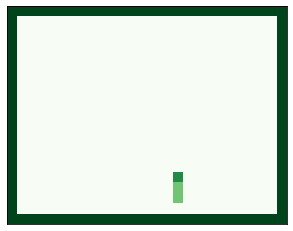

main loop:


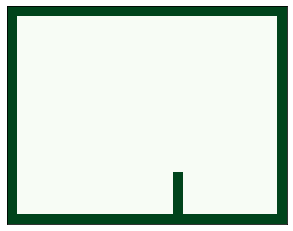

extend start with: (18, 4)
2:


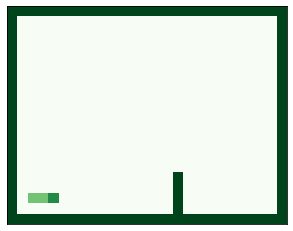

2:


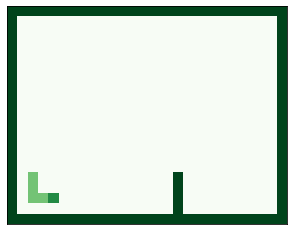

2:


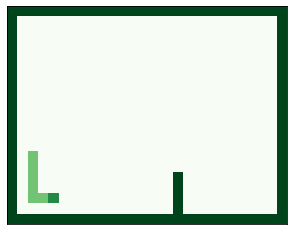

main loop:


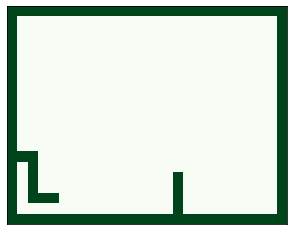

extend start with: (14, 18)
2:


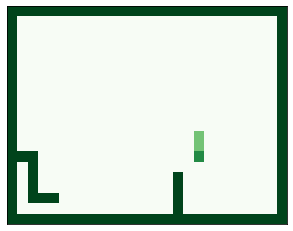

2:


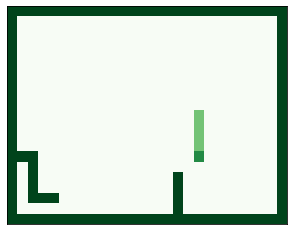

2:


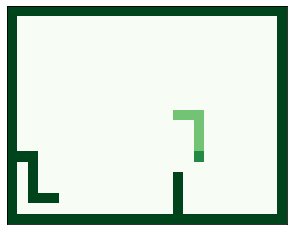

2:


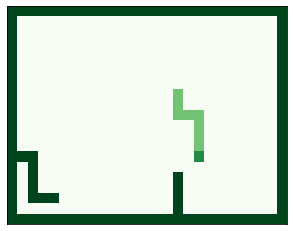

2:


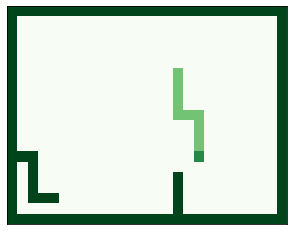

2:


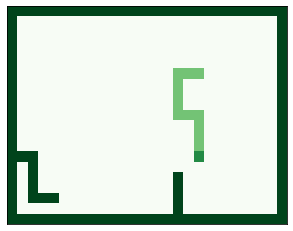

2:


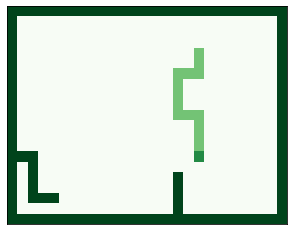

2:


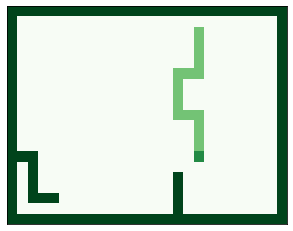

2:


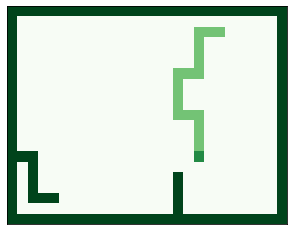

2:


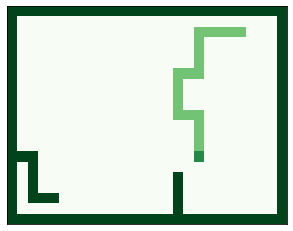

main loop:


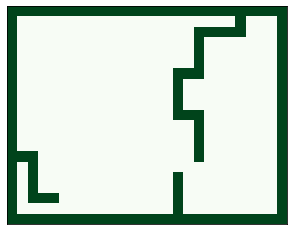

extend start with: (8, 2)
main loop:


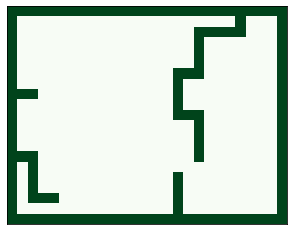

extend start with: (6, 24)
2:


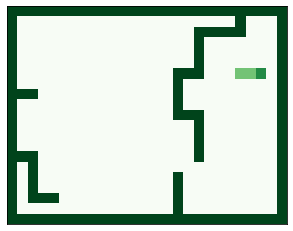

2:


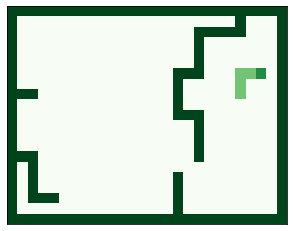

2:


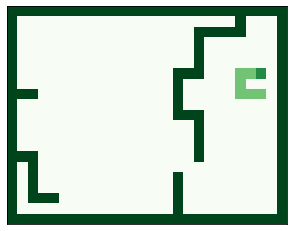

main loop:


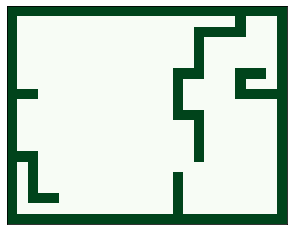

extend start with: (16, 18)
main loop:


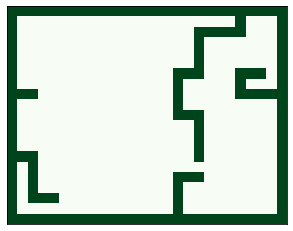

extend start with: (10, 8)
2:


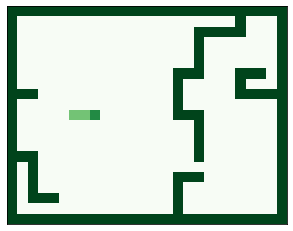

2:


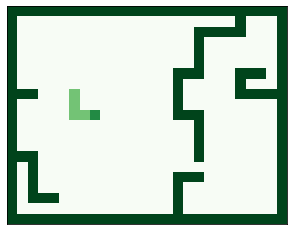

2:


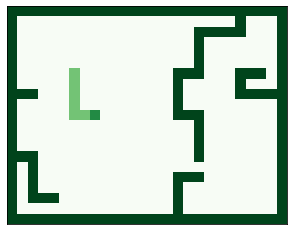

2:


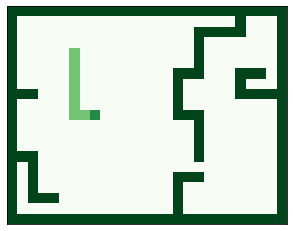

2:


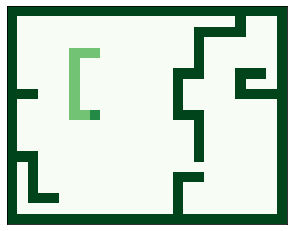

2:


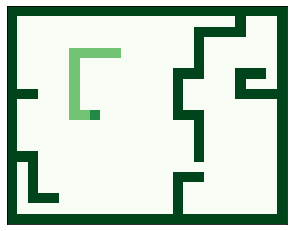

2:


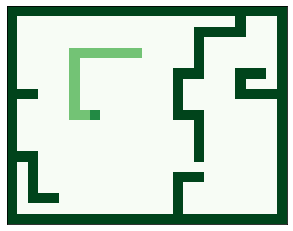

2:


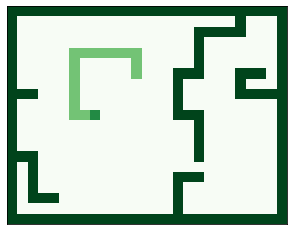

2:


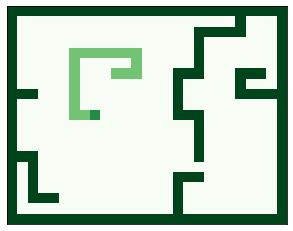

2:


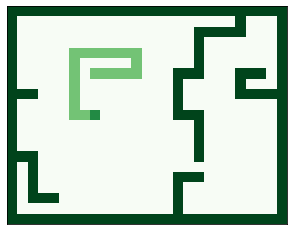

2:


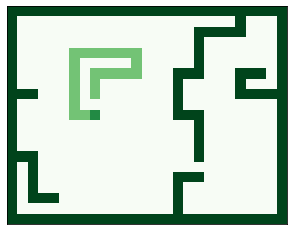

2:


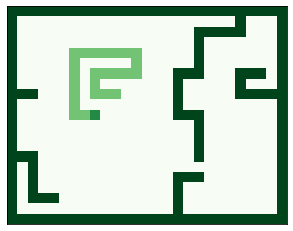

2:


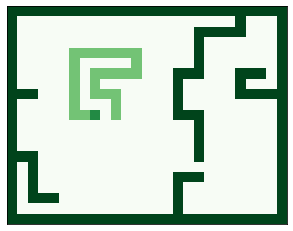

2:


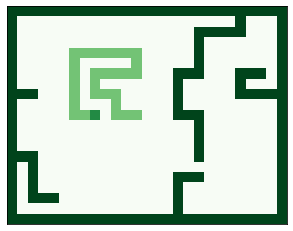

2:


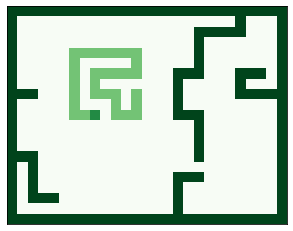

2:


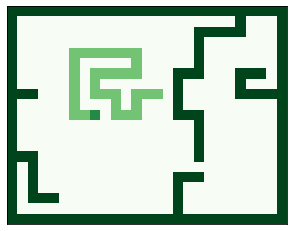

2:


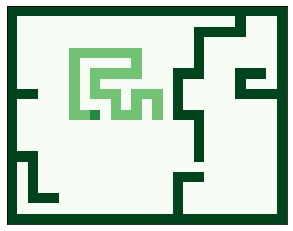

2:


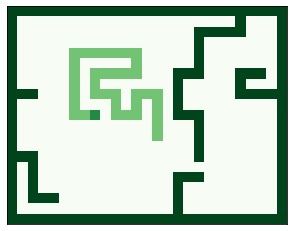

2:


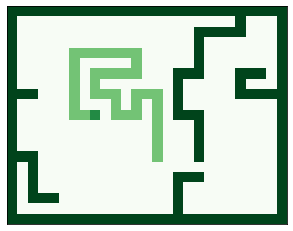

2:


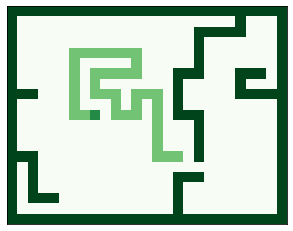

main loop:


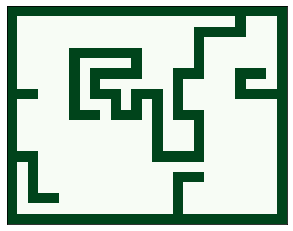

extend start with: (2, 10)
main loop:


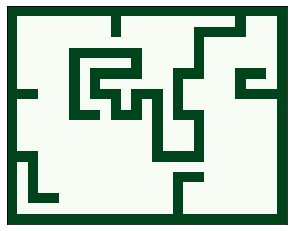

extend start with: (18, 6)
main loop:


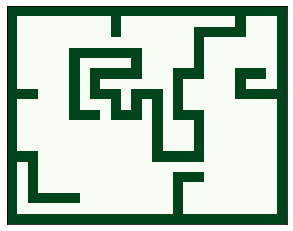

extend start with: (6, 4)
2:


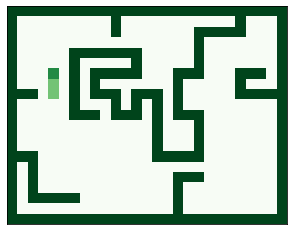

2:


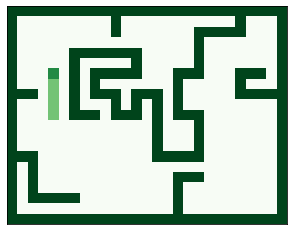

main loop:


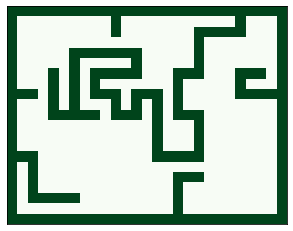

extend start with: (12, 24)
main loop:


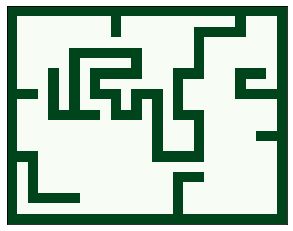

extend start with: (4, 24)
2:


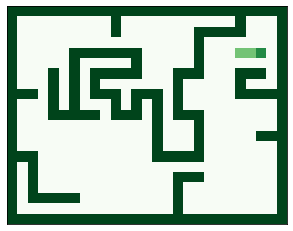

main loop:


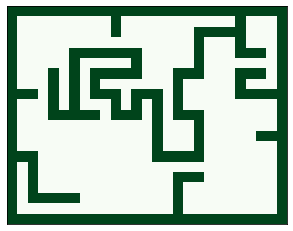

extend start with: (14, 10)
2:


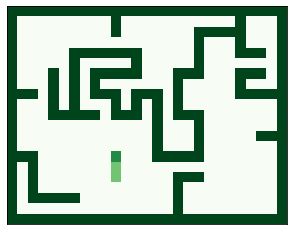

2:


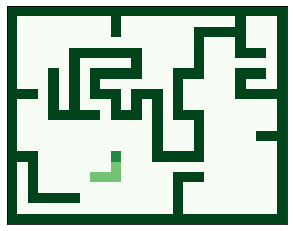

2:


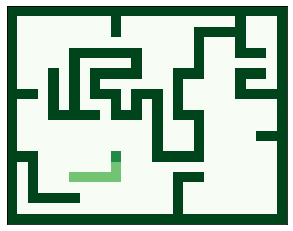

2:


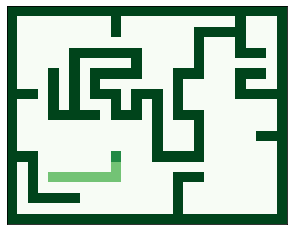

2:


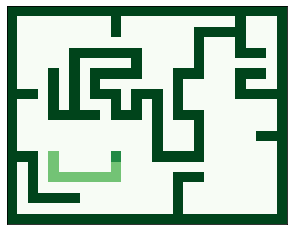

2:


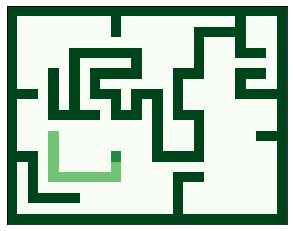

main loop:


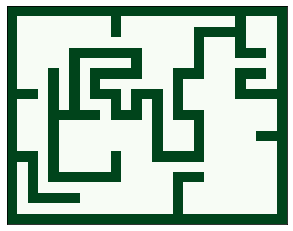

extend start with: (2, 2)
2:


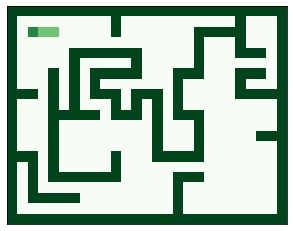

main loop:


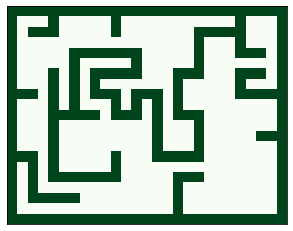

extend start with: (18, 8)
main loop:


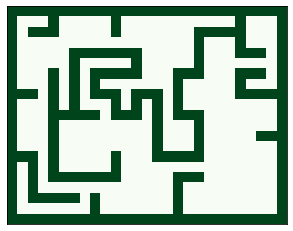

extend start with: (16, 24)
2:


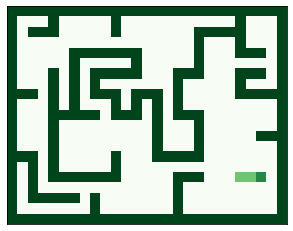

2:


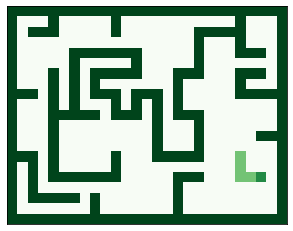

2:


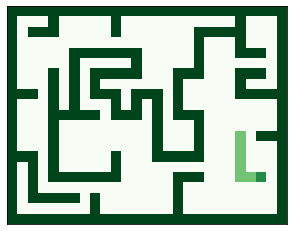

2:


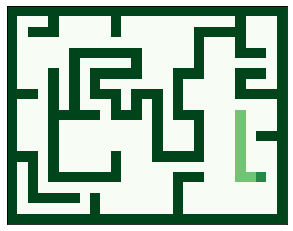

2:


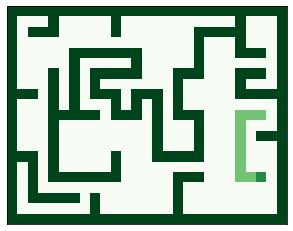

main loop:


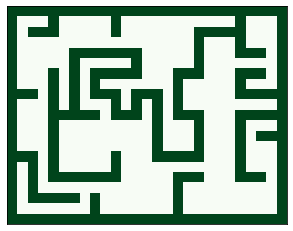

extend start with: (14, 8)
2:


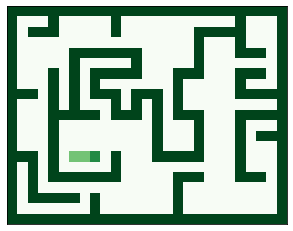

main loop:


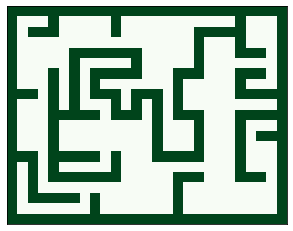

extend start with: (18, 20)
2:


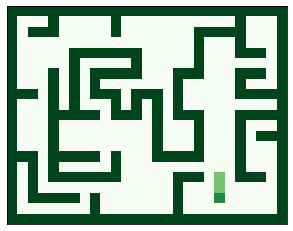

main loop:


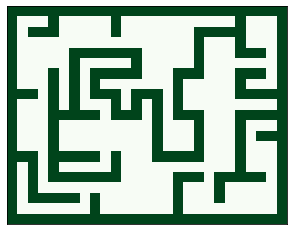

extend start with: (12, 2)
main loop:


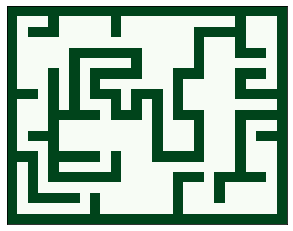

extend start with: (18, 12)
2:


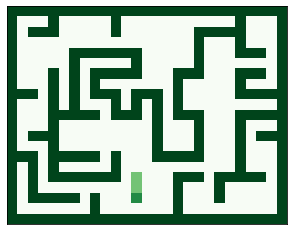

2:


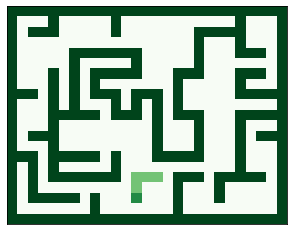

2:


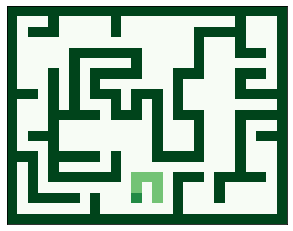

main loop:


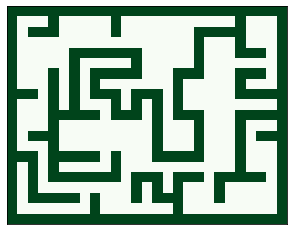

extend start with: (6, 20)
main loop:


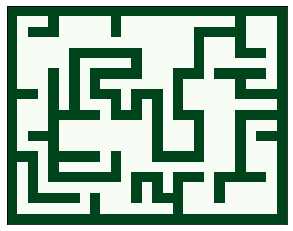

extend start with: (2, 14)
2:


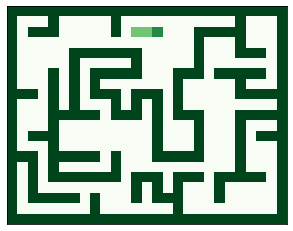

main loop:


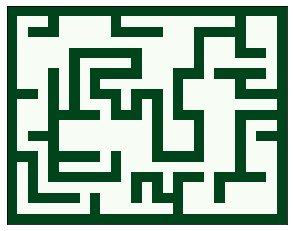

extend start with: (12, 12)
2:


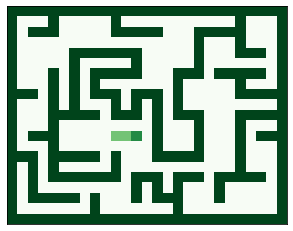

main loop:


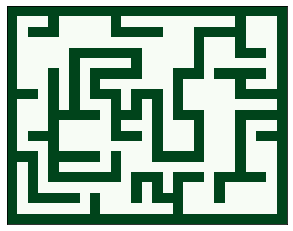

extend start with: (14, 24)
main loop:


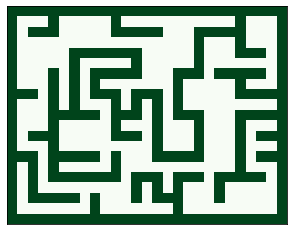

extend start with: (10, 20)
2:


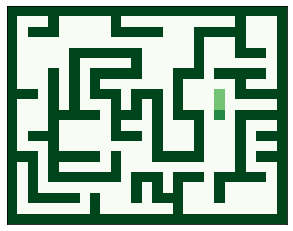

2:


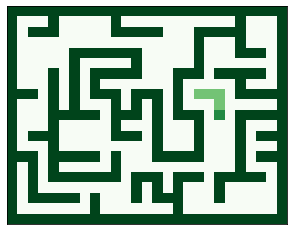

main loop:


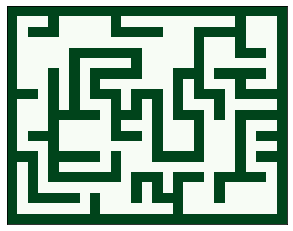

extend start with: (10, 2)
main loop:


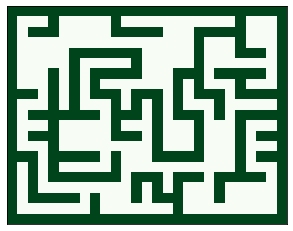

extend start with: (4, 14)
main loop:


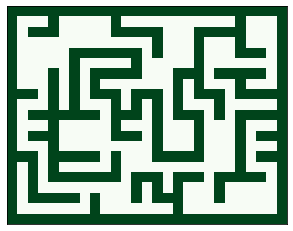

extend start with: (2, 8)
2:


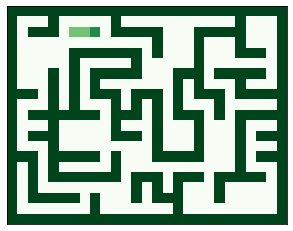

main loop:


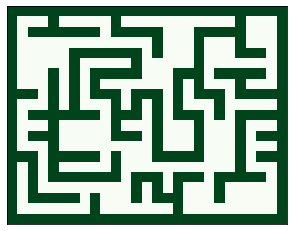

extend start with: (12, 20)
main loop:


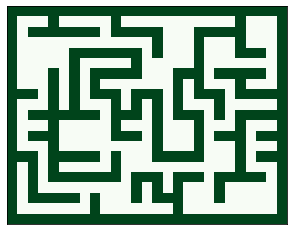

extend start with: (4, 2)
main loop:


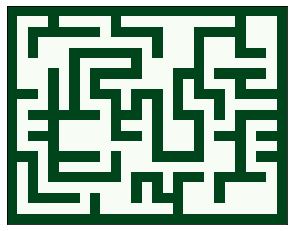

extend start with: (12, 16)
main loop:


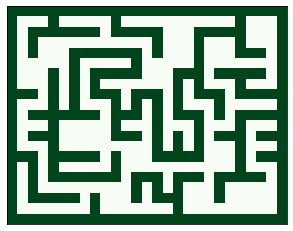

extend start with: (18, 10)
main loop:


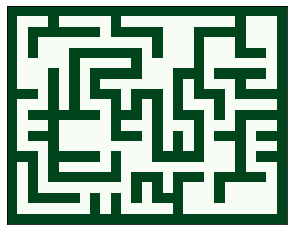

extend start with: (12, 6)
main loop:


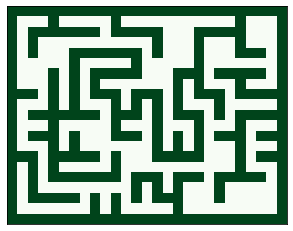

extend start with: (6, 14)
main loop:


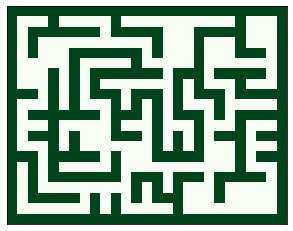

extend start with: (14, 20)
main loop:


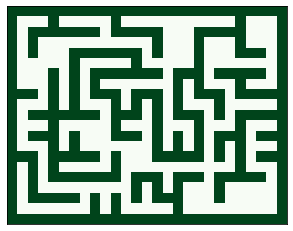

extend start with: (14, 12)
main loop:


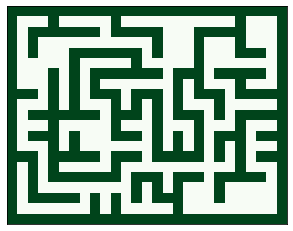

extend start with: (18, 22)
2:


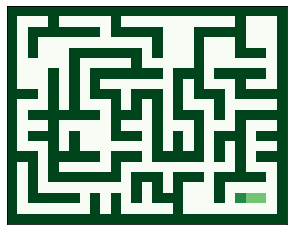

main loop:


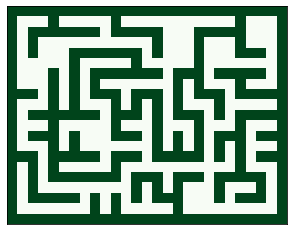

extend start with: (12, 8)
main loop:


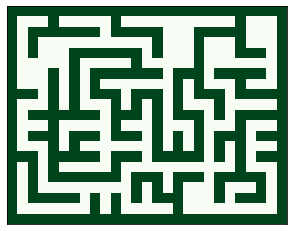

extend start with: (6, 2)
main loop:


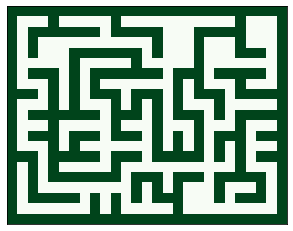

extend start with: (18, 18)
main loop:


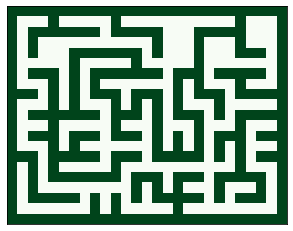

extend start with: (4, 4)
main loop:


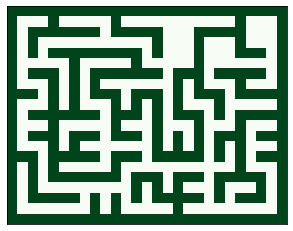

extend start with: (2, 16)
2:


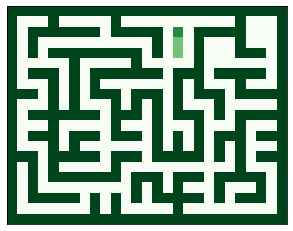

main loop:


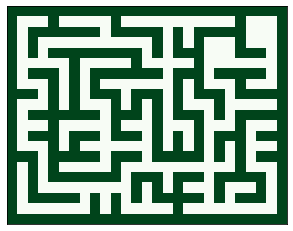

extend start with: (4, 20)
main loop:


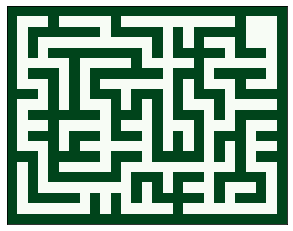

extend start with: (2, 24)
main loop:


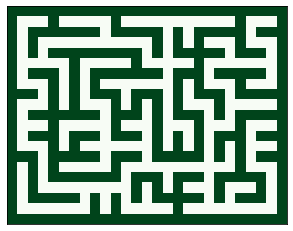

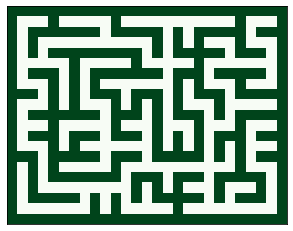

In [2]:
show_maze(None, 21, 27, verbose=True)